This notebook contains contains the analysis of simulated data for the `constclust` manuscript. It also serves as a high level overview of `constclust` usage.

# Setup

First we'll import everything we need and make sure our environment is ready to go.

In [1]:
# Making a directory to cache results to
!mkdir -p cache

## Imports

In [2]:
from constclust import cluster, reconcile, plotting

import scanpy as sc
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score

## Function for simulating data

In [3]:
%load_ext rpy2.ipython
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

In [4]:
%%R
suppressMessages(library(splatter))
suppressMessages(library(scater))

In [5]:
def splatter_simulate_groups(sizes: "Collection[float]", total_cells: int = 5000) -> sc.AnnData:
    """
    Simulate simple single cell dataset.
    """
    sizes = np.array(sizes)
    %R -i sizes,total_cells sim = splatSimulate(group.prob=as.numeric(sizes), method="groups", batchCells=total_cells, seed=42)
    %R sim = logNormCounts(sim)
    with localconverter(ro.default_converter + pandas2ri.converter):
        adata = sc.AnnData(
            X=sparse.csr_matrix(
                ro.r("t(logcounts(sim))"),
                dtype="float32"
            ),
            obs=ro.r("as.data.frame(colData(sim))"),
            var=ro.r("as.data.frame(rowData(sim))")
        )
    return adata

## Helper function for aggregating components to flat labelling

In [6]:
def flat_labelling(complist, obs_names: pd.Index) -> pd.Series:
    """Convenience function for creating a flat labelling from some components."""
    solution = pd.Series("", index=obs_names)
    for i, comp in enumerate(complist):
        if (solution.loc[comp.intersect_names] != "").any():
            print(f"Overlap from {i}")
        solution.loc[comp.intersect_names] = str(i)
    return solution

# Evenly sized datasets

The first dataset we'll look at has four evenly sized groups. This should be a fairly simple case.

### Generate

In [7]:
even = splatter_simulate_groups([.25, .25, .25, .25])

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating group DE...

R[write to console]: Simulating cell means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Sparsifying assays...

R[write to console]: Automatically converting to sparse matrices, threshold = 0.95

R[write to console]: Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'BCV': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix

R[write to console]: Skipping 'TrueCounts': estimated sparse size 1.61 * dense matrix

R[write to consol

In [8]:
sc.pp.pca(even)
sc.pp.neighbors(even)
sc.tl.umap(even)
sc.tl.leiden(even)

We can see that the true clustering is found quite readily. This is not suprising for such a simple case.

... storing 'Batch' as categorical


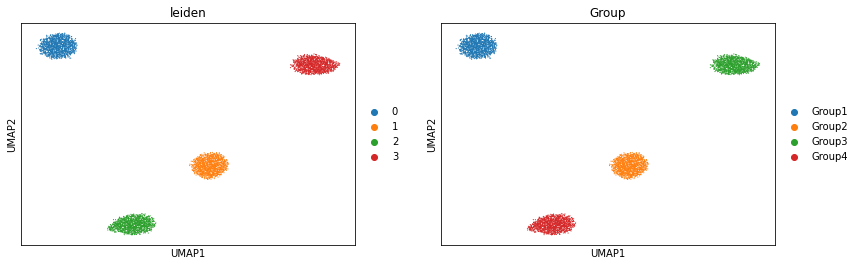

In [9]:
sc.pl.umap(even, color=["leiden", "Group"], size=5)

### Cluster many times

Now we'll cluster this dataset many times. For maximum compatibility we'll use a `multiprocessing` backend to perform the clustering in parallel, but this can be done more efficiently with an optimizing scheduler like `dask`.

In [10]:
%%time
even_params, even_clusterings = cluster(
    even,
    n_neighbors=np.linspace(15, 90, 6, dtype=np.int),
    resolutions=np.geomspace(0.01, 100, 40),
    random_state=[0, 1, 2],
    n_procs=6
)

Finding communities: 100%|██████████| 720/720 [03:35<00:00,  3.34it/s]


CPU times: user 4min 9s, sys: 9.17 s, total: 4min 18s
Wall time: 4min


Since it can take a while to compute all these clusterings, it's recommended to cache the intermediate results.

In [11]:
pd.to_pickle(even_params, "cache/even_params.pkl")
pd.to_pickle(even_clusterings, "cache/even_clusterings.pkl")

In [12]:
even_params = pd.read_pickle("cache/even_params.pkl")
even_clusterings = pd.read_pickle( "cache/even_clusterings.pkl")

### Reconcile the solutions

Now we will reconcile the clusters from each solution together by building a connectivity graph of clusterings from neighbouring clusterings. Each node in this graph is a cluster from one clustering solution. Thinking of the parameter space defined by the ordered parameters as a grid, we make comparisons between clusterings only one step away on this grid. This is because we expect similar solutions from similar parametrizations. Edges are added between nodes (clusters) which have an overlapping observations. These edges are weighted by the Jaccard similarity of these clusters.

The resulting graph is stored in a `Reconciler` object. This object stores the clusterings, parameters, and the connectivity graph, and has methods for selecting components and computing statistics on the clusterings.

In [13]:
%%time
even_rec = reconcile(even_params, even_clusterings)
even_rec

CPU times: user 5.32 s, sys: 222 ms, total: 5.54 s
Wall time: 5.53 s


<Reconciler 720 clusterings, 153137 clusters, 5000 cells>

Looking at the distribution of edge weights (Jaccard similarities) we can see a peak at 1.0 for clusters which are extremly similar. Some symmetry around 0.5 can also be seen. This is explained by cases where existing clusters are split into two, yielding a pair of edges to divided clustering whose weights sum to 1.

<AxesSubplot:ylabel='Count'>

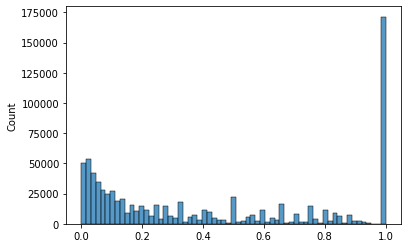

In [14]:
plotting.edge_weight_distribution(even_rec)

In [15]:
%%time
even_comps = even_rec.get_components(0.98)

CPU times: user 7.77 s, sys: 38 ms, total: 7.8 s
Wall time: 7.81 s


To select consistent clusters, we will pick sets of clusters with high similarity. Here we are setting an edge weight based cutoff and segmenting the connected components that remain.

The `Reconciler.get_components` method returns a `ComponentList` which stores an ordered set of components associated with a `Reconciler` with methods for selecting, computing statistics, and plotting the components.

In [16]:
even_comps.describe().sort_values("n_solutions", ascending=False)  # Looking at some statistics

,n_solutions,n_intersect,n_union
component,,,
0,432,1229,1229
1,431,1238,1238
2,430,1245,1245
3,429,1288,1288
4,133,6,6
...,...,...,...
8228,2,9,9
8229,2,9,9
8230,2,9,9


The correct solutions clearly stand out:

<AxesSubplot:xlabel='n_solutions', ylabel='n_intersect'>

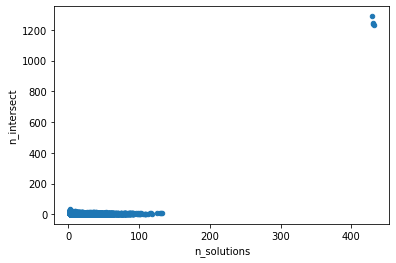

In [17]:
even_comps.describe().plot.scatter("n_solutions", "n_intersect")

We can take a look at these components on a 2D embedding here, as well as the regions of parameter space their constituent clusters were generated by:

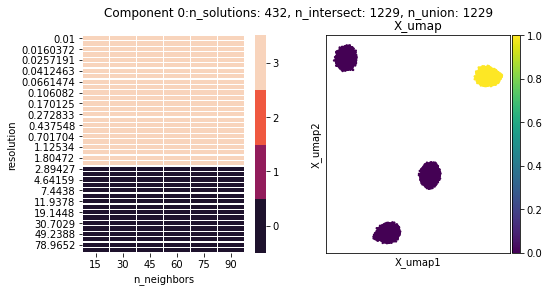

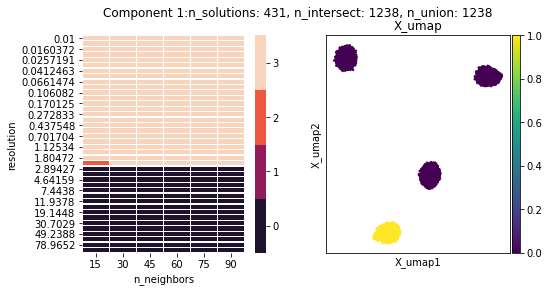

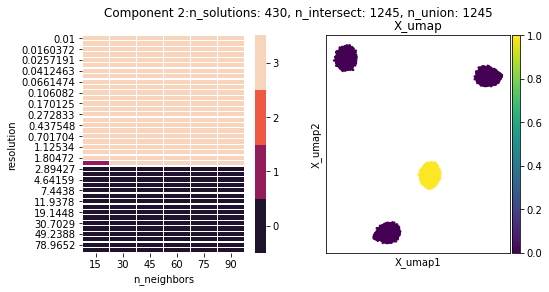

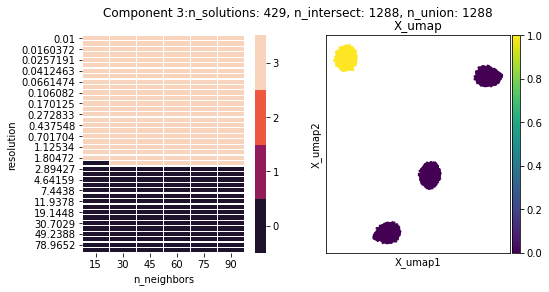

In [18]:
even_comps[:4].plot_components(even)

The embeddings above are colored by the frequency with which each observation showed up in a component (over the number of components).

### Some bad solutions

We can also take a look at the later solutions. I'd note that the groupings seems largely random, and contain very few samples.

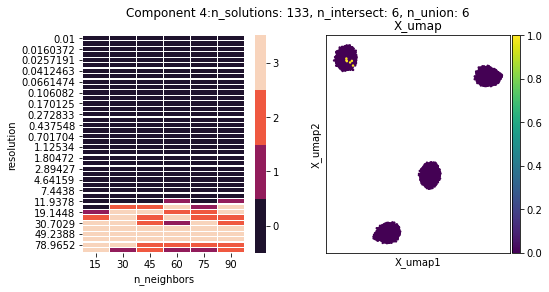

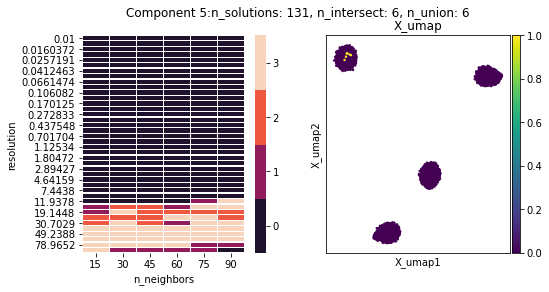

In [19]:
even_comps[4:6].plot_components(even)

### Comparison with ground truth

We can compare the selected components with a ground truth labelling:

In [20]:
even_computed_labels = flat_labelling(even_comps[:4], even.obs_names)
even_true_labels = even.obs["Group"]

In [21]:
adjusted_rand_score(even_true_labels, even_computed_labels)

1.0

And find that they are a perfect match.

# Unevenly sized datasets

Now we will look at a dataset where planted clusters vary widely in size. Simulating again with `splatter`:

In [22]:
uneven = splatter_simulate_groups([.9, .09, .009, .001], 10000)

R[write to console]: Getting parameters...

R[write to console]: Creating simulation object...

R[write to console]: Simulating library sizes...

R[write to console]: Simulating gene means...

R[write to console]: Simulating group DE...

R[write to console]: Simulating cell means...

R[write to console]: Simulating BCV...

R[write to console]: Simulating counts...

R[write to console]: Simulating dropout (if needed)...

R[write to console]: Sparsifying assays...

R[write to console]: Automatically converting to sparse matrices, threshold = 0.95

R[write to console]: Skipping 'BatchCellMeans': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'BaseCellMeans': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'BCV': estimated sparse size 1.5 * dense matrix

R[write to console]: Skipping 'CellMeans': estimated sparse size 1.49 * dense matrix

R[write to console]: Skipping 'TrueCounts': estimated sparse size 1.64 * dense matrix

R[write to consol

In [23]:
uneven.obs["Group"].value_counts()  # Getting a count of each group

Group1    8969
Group2     930
Group3      86
Group4      15
Name: Group, dtype: int64

In [24]:
sc.pp.pca(uneven)
sc.pp.neighbors(uneven)
sc.tl.umap(uneven)
sc.tl.leiden(uneven)

... storing 'Batch' as categorical


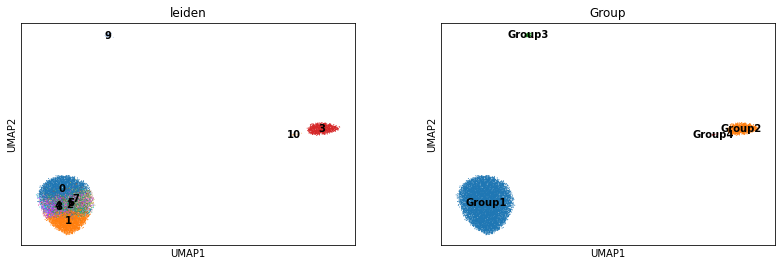

In [25]:
sc.pl.umap(uneven, color=["leiden", "Group"], size=4, ncols=2, legend_loc="on data")

As we can see here, with default settings we don't identify the largest group, and instead finds spurious partitions. So, looking at other parameterizations:

In [26]:
%%time
params, clusts = cluster(
    uneven,
    n_neighbors=np.linspace(15, 90, 6, dtype=np.int),
    resolutions=np.geomspace(0.01, 100, 40),
    random_state=[0, 1, 2],
    n_procs=12,
)

Finding communities: 100%|██████████| 720/720 [08:23<00:00,  1.43it/s]


CPU times: user 12min 15s, sys: 33.9 s, total: 12min 49s
Wall time: 13min 18s


### Caching

In [27]:
pd.to_pickle(params, "cache/uneven_params.pkl")
pd.to_pickle(clusts, "cache/uneven_clusterings.pkl")

In [28]:
params = pd.read_pickle("cache/uneven_params.pkl")
clusts = pd.read_pickle( "cache/uneven_clusterings.pkl")

## Analysis

Now we'll run through the analysis workflow, as we for the even case above.

In [29]:
%%time
r = reconcile(params, clusts)

CPU times: user 3.82 s, sys: 462 ms, total: 4.28 s
Wall time: 4.25 s


<AxesSubplot:ylabel='Count'>

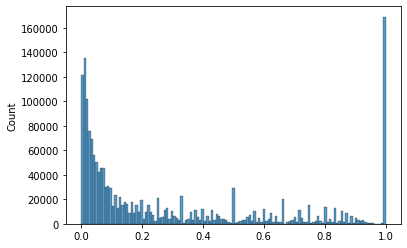

In [30]:
plotting.edge_weight_distribution(r)

In [31]:
%%time
comps = r.get_components(0.9)

CPU times: user 16.8 s, sys: 105 ms, total: 16.9 s
Wall time: 16.9 s


<AxesSubplot:xlabel='n_solutions', ylabel='n_intersect'>

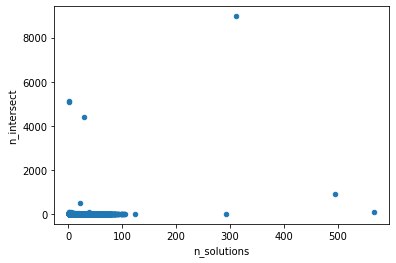

In [32]:
comps.describe().plot.scatter("n_solutions", "n_intersect")

While there is more variation in stability, there are still four components which are clear outliers. Looking at these in more depth:

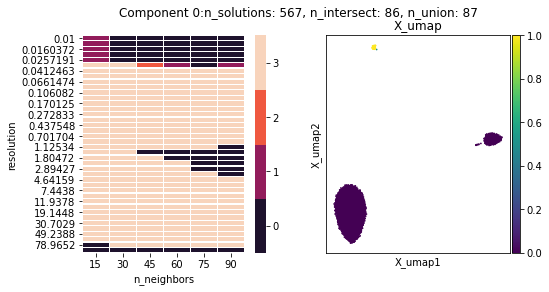

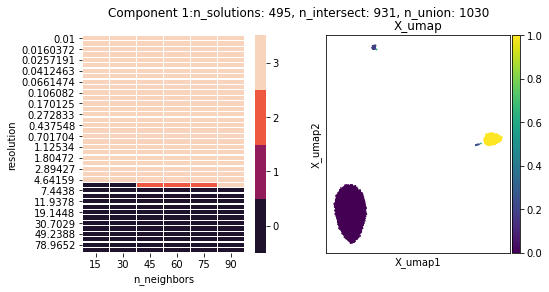

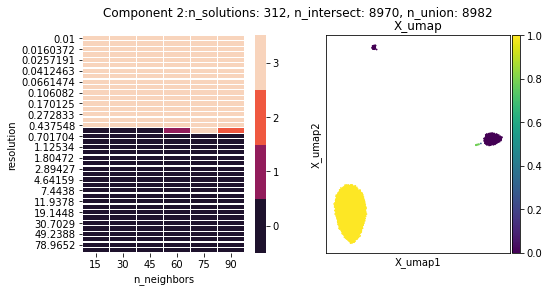

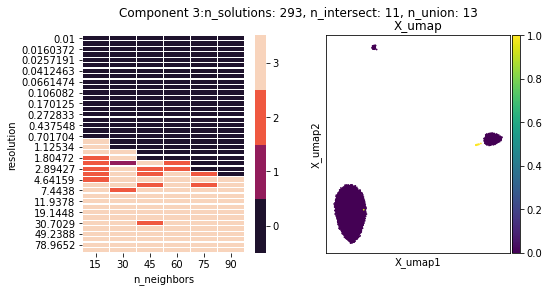

In [33]:
comps[:4].plot_components(uneven)

In [34]:
uneven.obs["constclust"] = flat_labelling(comps[:4], uneven.obs_names)

... storing 'constclust' as categorical


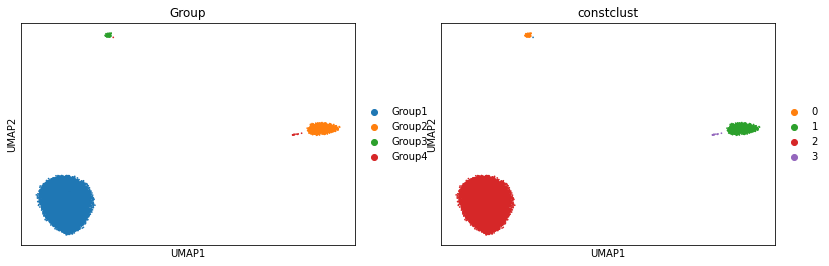

In [35]:
sc.pl.umap(uneven, color=["Group", "constclust"])

In [36]:
adjusted_rand_score(uneven.obs["Group"], uneven.obs["constclust"])

0.9993449612562323

# Version info:

In [37]:
from sinfo import sinfo

In [38]:
sinfo(dependencies=True)

-----
anndata     0.7.5
constclust  v0.1.1+38.gf19f7ed.dirty
matplotlib  3.3.3
numpy       1.19.4
pandas      1.1.4
rpy2        3.3.6
scanpy      1.6.0
scipy       1.5.4
sinfo       0.3.1
sklearn     0.23.2
-----
PIL                 8.0.1
anndata             0.7.5
appnope             0.1.2
backcall            0.2.0
cffi                1.14.4
cloudpickle         1.6.0
constclust          v0.1.1+38.gf19f7ed.dirty
cycler              0.10.0
cython_runtime      NA
dask                2.30.0
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.2
joblib              0.17.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.3
mpl_toolkits        NA
natsort             7.1.0
networkx            2.5
numba              

In [39]:
%R print(sessionInfo());

R version 4.0.1 (2020-06-06)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /Users/isaac/miniconda3/envs/constclust-release/lib/libopenblasp-r0.3.10.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] scater_1.18.0               ggplot2_3.3.2              
 [3] splatter_1.14.0             SingleCellExperiment_1.12.0
 [5] SummarizedExperiment_1.20.0 Biobase_2.50.0             
 [7] GenomicRanges_1.42.0        GenomeInfoDb_1.26.0        
 [9] IRanges_2.24.0              S4Vectors_0.28.0           
[11] BiocGenerics_0.36.0         MatrixGenerics_1.2.0       
[13] matrixStats_0.57.0         

loaded via a namesp